**4.1** Create a new column **Call**.<br>
Train a classification model with 3 bollinger columns and stock price as inpuits and Call as output.<br>
Import another stock data and use the model for predicting **Call** using the input.

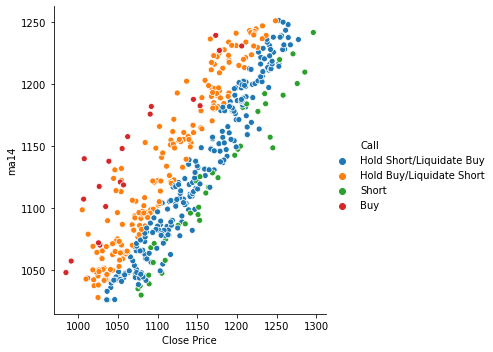

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn import neighbors,svm,linear_model,tree,ensemble
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline

stock = pd.read_csv('output/week2GOOG_reverse.csv',skiprows=list(range(1,14)))    # do not read the elements where ma or stdev is 0

stock['BOLU'] = stock['ma14'] + 2*stock['standardDeviation']    # create columns for upper and lower bollinger bands
stock['BOLD'] = stock['ma14'] - 2*stock['standardDeviation']
stock['Call'] = 'Call'    # creating a column for Call

stock.loc[stock['Close Price']<stock['BOLD'],'Call'] = 'Buy'
stock.loc[(stock['Close Price']>=stock['BOLD'])&(stock['Close Price']<stock['ma14']),'Call'] = 'Hold Buy/Liquidate Short'
stock.loc[(stock['Close Price']<=stock['BOLU'])&(stock['Close Price']>=stock['ma14']),'Call'] = 'Hold Short/Liquidate Buy'
stock.loc[stock['Close Price']>stock['BOLU'],'Call'] = 'Short'

sns.relplot(x='Close Price',y='ma14',hue='Call',data=stock)   # visualizing the relationship

In [5]:
X = stock[['Close Price','ma14','BOLU','BOLD']].values.reshape(-1,4)
X = normalize(X)    # normalizing the inputs
Y = stock['Call'].values

model1 = neighbors.KNeighborsClassifier(3)    # KNN model checks for the labels of 3 nearest neighbors with weights uniform
model1.fit(X,Y)

model2 = neighbors.KNeighborsClassifier(3,weights='distance')   # checks with weights as distance
model2.fit(X,Y)

model3 = linear_model.LogisticRegression(penalty='none',max_iter=330)    # logistic regression model
model3.fit(X,Y)

model4 = svm.SVC()    # SVM with RBF kernel
model4.fit(X,Y)

model5 = tree.DecisionTreeClassifier()
model5.fit(X,Y)

model6 = ensemble.RandomForestClassifier()
model6.fit(X,Y)

# have trained the models, import a stock to check the predictions

gail = pd.read_csv('data/Large_Cap/GAIL.csv')   # reading the stock GAIL

gail['ma14'] = gail['Average Price'].rolling(14).mean()   # SMA for 14 days. Average Price used for the calculation
gail['stdev'] = gail['Average Price'].rolling(14).std()   # Standard Deviation for last 14 days
gail['BOLU'] = gail['ma14']+2*gail['stdev']   # Bollinger Upper band
gail['BOLD'] = gail['ma14']-2*gail['stdev']   # Bollinger Lower band

gail['ExpectedCall'] = 'Call'    # creating a column for ExpectedCall to measure the accuracy
gail.loc[gail['Close Price']<gail['BOLD'],'ExpectedCall'] = 'Buy'
gail.loc[(gail['Close Price']>=gail['BOLD'])&(gail['Close Price']<gail['ma14']),'ExpectedCall'] = 'Hold Buy/Liquidate Short'
gail.loc[(gail['Close Price']<=gail['BOLU'])&(gail['Close Price']>=gail['ma14']),'ExpectedCall'] = 'Hold Short/Liquidate Buy'
gail.loc[gail['Close Price']>gail['BOLU'],'ExpectedCall'] = 'Short'

gail = gail.dropna()

# choosing the Logistic Regression model to predict the calls, model3
Xgail = gail[['Close Price','ma14','BOLU','BOLD']].values.reshape(-1,4)   # for predicting
Xgail = normalize(Xgail)    # normalizing the inputs
Ygail = gail['ExpectedCall'].values   # for checking accuracy
predictedCall = model3.predict(Xgail)
# model3.score(Xgail,Ygail)   # the accuracy
gail['PredictedCall'] = predictedCall   # saving the predicted calls

print('Accuracies :')   # checking the accuracies
print('KNN Classifier (uniform weights) :',model1.score(Xgail,Ygail))
print('KNN Classifier (weights=distance) :',model2.score(Xgail,Ygail))
print('Logistic Regression :',model3.score(Xgail,Ygail))
print('SVM (RBF kernel) :',model4.score(Xgail,Ygail))
print('Decision Tree :',model5.score(Xgail,Ygail))
print('Random Forest Classifier :',model6.score(Xgail,Ygail))

gail[['ExpectedCall','PredictedCall']]    # for visualizing the values

Accuracies :
KNN Classifier (uniform weights) : 0.9480249480249481
KNN Classifier (weights=distance) : 0.9563409563409564
Logistic Regression : 0.9916839916839917
SVM (RBF kernel) : 0.9126819126819127
Decision Tree : 0.9584199584199584
Random Forest Classifier : 0.9584199584199584


,ExpectedCall,PredictedCall
13,Hold Short/Liquidate Buy,Hold Short/Liquidate Buy
14,Hold Short/Liquidate Buy,Hold Short/Liquidate Buy
15,Hold Buy/Liquidate Short,Hold Buy/Liquidate Short
16,Hold Buy/Liquidate Short,Hold Buy/Liquidate Short
17,Hold Short/Liquidate Buy,Hold Short/Liquidate Buy
...,...,...
489,Hold Buy/Liquidate Short,Hold Buy/Liquidate Short
490,Hold Buy/Liquidate Short,Hold Buy/Liquidate Short
491,Hold Buy/Liquidate Short,Hold Buy/Liquidate Short
492,Hold Buy/Liquidate Short,Hold Buy/Liquidate Short


**4.2** Import stock data file of choice. Define 4 columns :
* open close percentage
* high low percentage
* 5 day rolling mean of day to day percentage
* 5 day rolling standard deviation of day to day percentage
Create a new column **Action**, and assign values on basis of **Close Price**.<br>
Construct a random forest classification model with four columns as inputs, and **Action** as target.<br>
Check accuracy of this model, plot the net cumulative returns.


Accuracy for test data :  0.4855072463768116


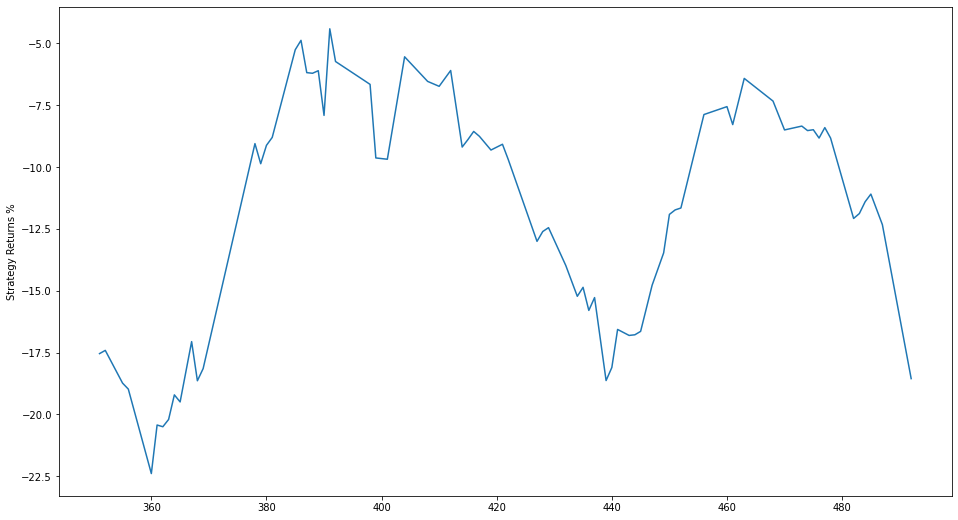

In [6]:
godrej = pd.read_csv('data/Mid_Cap/GODREJIND.csv')

close = godrej['Close Price'].values    
close = close[1:]
godrej.loc[:godrej.index[-1]-1,'NextClose'] = close   # add a column for next day closing prices

first = godrej.loc[0,'Close Price']
godrej['cumulativePer'] = (godrej['Close Price'] - first)*100/first   # add a column of cumulative percentages for plotting purpose

godrej['OCper'] = (godrej['Close Price']-godrej['Open Price'])/godrej['Open Price']   # not multiplied with 100 just to be equivalent with pct_change()
godrej['HLper'] = (godrej['High Price']-godrej['Low Price'])/godrej['Low Price']
godrej['dayPerChange'] = godrej['Close Price'].pct_change()
godrej['rolMean'] = godrej['dayPerChange'].rolling(5).mean()
godrej['rolstd'] = godrej['dayPerChange'].rolling(5).std()

godrej = godrej.dropna()    # the rows containing NAs for any columns dropped

pd.options.mode.chained_assignment = None   # deal with Setting with Copy warning
godrej.loc[godrej['Close Price']<=godrej['NextClose'],'action'] = 1
godrej.loc[godrej['Close Price']>godrej['NextClose'],'action'] = -1

modelrf = ensemble.RandomForestClassifier()

Xgodrej = godrej[['OCper','HLper','rolMean','rolstd']].values.reshape(-1,4)
# Xgodrej = normalize(Xgodrej)    # not normalizing since they are already in range 0 to 1
Ygodrej = godrej['action'].values

# XgodrejTrain, XgodrejTest, YgodrejTrain, YgodrejTest = train_test_split(Xgodrej,Ygodrej,train_size=0.5,test_size=0.5)
XgodrejTrain, XgodrejTest = Xgodrej[:350,:],Xgodrej[350:,:]   # although we could have used train_test_split but for ease in plotting
YgodrejTrain, YgodrejTest = Ygodrej[:350],Ygodrej[350:]

modelrf.fit(XgodrejTrain,YgodrejTrain)

print('Accuracy for test data : ',modelrf.score(XgodrejTest,YgodrejTest))   # printing the accuracy of model on test set

godrej['Predicted Action'] = modelrf.predict(Xgodrej)   # predicting actions on the entire data
cumPer = godrej.loc[(godrej.index >= 350)&(godrej['Predicted Action']==1),'cumulativePer']    # choosing the data of the test set to be plotted

plt.figure(figsize=(16,9))
plt.plot(cumPer)    # the plot appears negative because we're taking the actions on the basis of today's and next day's close price, not on the basis of cumulative percentage
plt.ylabel('Strategy Returns %')
plt.show()